### Imports

In [1]:
%matplotlib notebook  
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
from pathlib import Path

# importing model and loss function
from model.alt_loss_A import Loss
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

# importing training utility functions
#from model.training_kde import select_gpu, Results, trainNet
from functions.new_training_kde import select_gpu, Results, trainNet
from model.plots import dual_train_plots, replace_in_ax
from model.collectdata_poca_KDE import collect_data_poca
from functions.utils import vector_to_state_dict, state_dict_to_vector

# importing modified optimizers
from functions.new_optimizers import Adam, reversible_Adam, EpochEVE 

# shows GPU usage
!nvidia-smi

Tue Sep 21 16:16:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 32%   45C    P2    35W / 250W |  11211MiB / 12066MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

### Set up training parameters

In [2]:
# the output folder the results are stored in 
name   = 'example'

# note that baileyds is a symbolic link to a directory on share/lazy/
folder = 'baileyds/AllCNN/' + name
output = Path(folder)
output.mkdir(exist_ok=True)

n_epochs = 50
batch_size = 128 
learning_rate = 5e-5
# choose gpu to use (or cpu)
device = "cuda:2"

In [3]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

### Load data

In [4]:
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
  #                          device=device,
                            masking=True,
                            shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 16.12 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 16.36 s
Constructing 160000 event dataset took 0.504 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 3.978 s
Constructing 20000 event dataset took 0.07167 s


### Load model and loss function

In [5]:
model = Model()
model.to(device)

loss = Loss(epsilon=1e-5,coefficient=2.5)

### Load parameters from pretrained model if desired

In [6]:
# d_folder = 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'
# suffix = '0'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_folder + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)
# model.load_state_dict(pretrained_dict,strict=False)

### Choose optimizers

In [7]:
optimizer = reversible_Adam(model.parameters(), lr=learning_rate)
ep_optimizer = None
lr_scheduler = None
careful = False
adaptive = 0.1 #adaptive Adam with increase factor of 0.1

### Set up plot for training

<IPython.core.display.Javascript object>


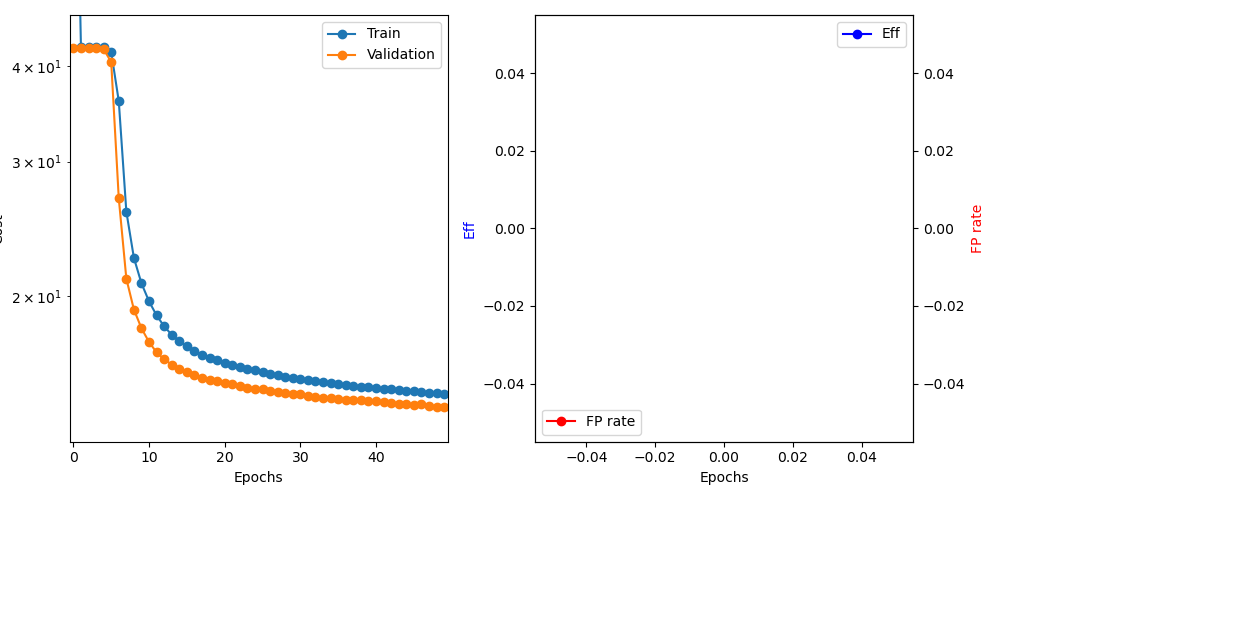

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

### Train the model

In [9]:
# save initial model state
param_states.append(get_param_state(model))
torch.save(model.state_dict(), output / f'{name}_init.pyt')

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start = len(results),
                        notebook = True,
                        ep_optimizer = ep_optimizer,
                        lr_scheduler = lr_scheduler,
                        careful = careful,
                        adaptive = adaptive
                      ):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))
    
# save final model and stats
torch.save(model.state_dict(), output / f'{name}_final.pyt')
results.to_hdf(f'{name}_stats.hdf5', 'results')

Number of batches: train = 1250, val = 157


Number of batches: train = 1250, val = 157


Epoch 0: train=129.505, val=42.2127, took 249.06 s


ADAPTIVE:
     dot: 0.208
     lr factor: 1.021
     lr changed to 5.103865697979927e-05
Epoch 1: train=42.3906, val=42.2069, took 243.1 s


ADAPTIVE:
     dot: 0.541
     lr factor: 1.054
     lr changed to 5.380076830965742e-05
Epoch 2: train=42.3873, val=42.2042, took 240.58 s


ADAPTIVE:
     dot: 0.175
     lr factor: 1.017
     lr changed to 5.474075595517223e-05
Epoch 3: train=42.3842, val=42.1993, took 259.15 s


ADAPTIVE:
     dot: 0.109
     lr factor: 1.011
     lr changed to 5.533972266712033e-05
Epoch 4: train=42.3546, val=42.0873, took 432.27 s


ADAPTIVE:
     dot: 0.599
     lr factor: 1.060
     lr changed to 5.86542684658032e-05
Epoch 5: train=41.7123, val=40.4644, took 437.09 s


ADAPTIVE:
     dot: 0.493
     lr factor: 1.049
     lr changed to 6.154612318117226e-05
Epoch 6: train=35.9881, val=26.8669, took 442.19 s


ADAPTIVE:
     dot: 0.304
     lr factor: 1.030
     lr changed to 6.341810253675083e-05
Epoch 7: train=25.8175, val=21.0979, took 440.52 s


ADAPTIVE:
     dot: 0.697
     lr factor: 1.070
     lr changed to 6.783790597134397e-05
Epoch 8: train=22.458, val=19.225, took 440.03 s


ADAPTIVE:
     dot: 0.622
     lr factor: 1.062
     lr changed to 7.205507635521795e-05
Epoch 9: train=20.802, val=18.1718, took 438.21 s


ADAPTIVE:
     dot: 0.542
     lr factor: 1.054
     lr changed to 7.595911589650979e-05
Epoch 10: train=19.7054, val=17.4349, took 440.49 s


ADAPTIVE:
     dot: 0.481
     lr factor: 1.048
     lr changed to 7.961145862337214e-05
Epoch 11: train=18.889, val=16.8998, took 440.67 s


ADAPTIVE:
     dot: 0.432
     lr factor: 1.043
     lr changed to 8.304934530281329e-05
Epoch 12: train=18.2789, val=16.5506, took 449.19 s


ADAPTIVE:
     dot: 0.385
     lr factor: 1.038
     lr changed to 8.624317350133706e-05
Epoch 13: train=17.8179, val=16.2936, took 452.59 s


ADAPTIVE:
     dot: 0.333
     lr factor: 1.033
     lr changed to 8.911356453723356e-05
Epoch 14: train=17.475, val=16.0699, took 449.18 s


ADAPTIVE:
     dot: 0.280
     lr factor: 1.028
     lr changed to 9.161265500741101e-05
Epoch 15: train=17.2024, val=15.9355, took 449.6 s


ADAPTIVE:
     dot: 0.240
     lr factor: 1.024
     lr changed to 9.380706382741034e-05
Epoch 16: train=16.9767, val=15.7708, took 450.46 s


ADAPTIVE:
     dot: 0.208
     lr factor: 1.021
     lr changed to 9.575999123861463e-05
Epoch 17: train=16.7906, val=15.6598, took 449.33 s


ADAPTIVE:
     dot: 0.181
     lr factor: 1.018
     lr changed to 9.749272705010143e-05
Epoch 18: train=16.6328, val=15.5753, took 452.79 s


ADAPTIVE:
     dot: 0.161
     lr factor: 1.016
     lr changed to 9.906005993903514e-05
Epoch 19: train=16.5073, val=15.4833, took 452.24 s


ADAPTIVE:
     dot: 0.145
     lr factor: 1.015
     lr changed to 0.00010049997579240639
Epoch 20: train=16.3835, val=15.4206, took 388.02 s


ADAPTIVE:
     dot: 0.134
     lr factor: 1.013
     lr changed to 0.00010184926823817327
Epoch 21: train=16.2772, val=15.356, took 448.45 s


ADAPTIVE:
     dot: 0.127
     lr factor: 1.013
     lr changed to 0.0001031426752188831
Epoch 22: train=16.1755, val=15.2954, took 445.15 s


ADAPTIVE:
     dot: 0.119
     lr factor: 1.012
     lr changed to 0.00010437205305247468
Epoch 23: train=16.0863, val=15.2044, took 444.96 s


ADAPTIVE:
     dot: 0.115
     lr factor: 1.011
     lr changed to 0.0001055673912302305
Epoch 24: train=16.0059, val=15.1589, took 443.06 s


ADAPTIVE:
     dot: 0.109
     lr factor: 1.011
     lr changed to 0.00010671595313589046
Epoch 25: train=15.9173, val=15.1168, took 449.55 s


ADAPTIVE:
     dot: 0.104
     lr factor: 1.010
     lr changed to 0.00010782808234803952
Epoch 26: train=15.8555, val=15.0577, took 330.15 s


ADAPTIVE:
     dot: 0.102
     lr factor: 1.010
     lr changed to 0.00010892728509791024
Epoch 27: train=15.7795, val=14.9949, took 240.22 s


ADAPTIVE:
     dot: 0.096
     lr factor: 1.010
     lr changed to 0.00010997647355517606
Epoch 28: train=15.7039, val=14.9428, took 245.08 s


ADAPTIVE:
     dot: 0.094
     lr factor: 1.009
     lr changed to 0.00011100641779652051
Epoch 29: train=15.6453, val=14.9076, took 249.57 s


ADAPTIVE:
     dot: 0.090
     lr factor: 1.009
     lr changed to 0.0001120040522222343
Epoch 30: train=15.595, val=14.8915, took 255.79 s


ADAPTIVE:
     dot: 0.087
     lr factor: 1.009
     lr changed to 0.0001129746521919551
Epoch 31: train=15.5388, val=14.8217, took 260.93 s


ADAPTIVE:
     dot: 0.085
     lr factor: 1.008
     lr changed to 0.00011392934262969652
Epoch 32: train=15.4897, val=14.7845, took 243.63 s


ADAPTIVE:
     dot: 0.081
     lr factor: 1.008
     lr changed to 0.00011484988624971509
Epoch 33: train=15.4427, val=14.7458, took 237.23 s


ADAPTIVE:
     dot: 0.077
     lr factor: 1.008
     lr changed to 0.00011573714607554944
Epoch 34: train=15.3961, val=14.717, took 241.31 s


ADAPTIVE:
     dot: 0.075
     lr factor: 1.007
     lr changed to 0.00011660262718632205
Epoch 35: train=15.3599, val=14.6721, took 263.03 s


ADAPTIVE:
     dot: 0.071
     lr factor: 1.007
     lr changed to 0.00011742688644990495
Epoch 36: train=15.317, val=14.6462, took 274.86 s


ADAPTIVE:
     dot: 0.068
     lr factor: 1.007
     lr changed to 0.00011822985095345674
Epoch 37: train=15.2819, val=14.6621, took 274.23 s


ADAPTIVE:
     dot: 0.067
     lr factor: 1.007
     lr changed to 0.0001190191963794979
Epoch 38: train=15.2435, val=14.6402, took 243.8 s


ADAPTIVE:
     dot: 0.064
     lr factor: 1.006
     lr changed to 0.0001197814050407933
Epoch 39: train=15.2065, val=14.5924, took 257.54 s


ADAPTIVE:
     dot: 0.065
     lr factor: 1.007
     lr changed to 0.00012056056896159569
Epoch 40: train=15.1724, val=14.5825, took 250.45 s


ADAPTIVE:
     dot: 0.059
     lr factor: 1.006
     lr changed to 0.00012127266152472776
Epoch 41: train=15.1436, val=14.5399, took 274.66 s


ADAPTIVE:
     dot: 0.059
     lr factor: 1.006
     lr changed to 0.0001219894489384816
Epoch 42: train=15.1156, val=14.5141, took 232.94 s


ADAPTIVE:
     dot: 0.058
     lr factor: 1.006
     lr changed to 0.00012269221803736674
Epoch 43: train=15.0805, val=14.4745, took 230.22 s


ADAPTIVE:
     dot: 0.056
     lr factor: 1.006
     lr changed to 0.00012338036579219702
Epoch 44: train=15.0509, val=14.4751, took 233.46 s


ADAPTIVE:
     dot: 0.054
     lr factor: 1.005
     lr changed to 0.00012405132292498948
Epoch 45: train=15.0264, val=14.4459, took 224.69 s


ADAPTIVE:
     dot: 0.052
     lr factor: 1.005
     lr changed to 0.00012470150034346258
Epoch 46: train=15.0001, val=14.4544, took 237.26 s


ADAPTIVE:
     dot: 0.051
     lr factor: 1.005
     lr changed to 0.00012534114281266613
Epoch 47: train=14.9761, val=14.4015, took 230.77 s


ADAPTIVE:
     dot: 0.054
     lr factor: 1.005
     lr changed to 0.0001260134016421856
Epoch 48: train=14.9496, val=14.3531, took 224.68 s


ADAPTIVE:
     dot: 0.052
     lr factor: 1.005
     lr changed to 0.00012667216188630355
Epoch 49: train=14.9188, val=14.3578, took 224.23 s



Save the plot above:

In [10]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

<IPython.core.display.Javascript object>

### Plotting the angle grid and step sizes

In [12]:
# getting angles between steps
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 30
num_epochs = n_epochs

ep_intervals = [(np.arange(0, num_epochs+1, grid_size)[i], np.arange(0, num_epochs+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)
    
    
# getting sizes of steps
step_sizes = []
for i in range(num_epochs-1):
    step_sizes.append(np.linalg.norm(param_states[i+1]-param_states[i]))

<IPython.core.display.Javascript object>


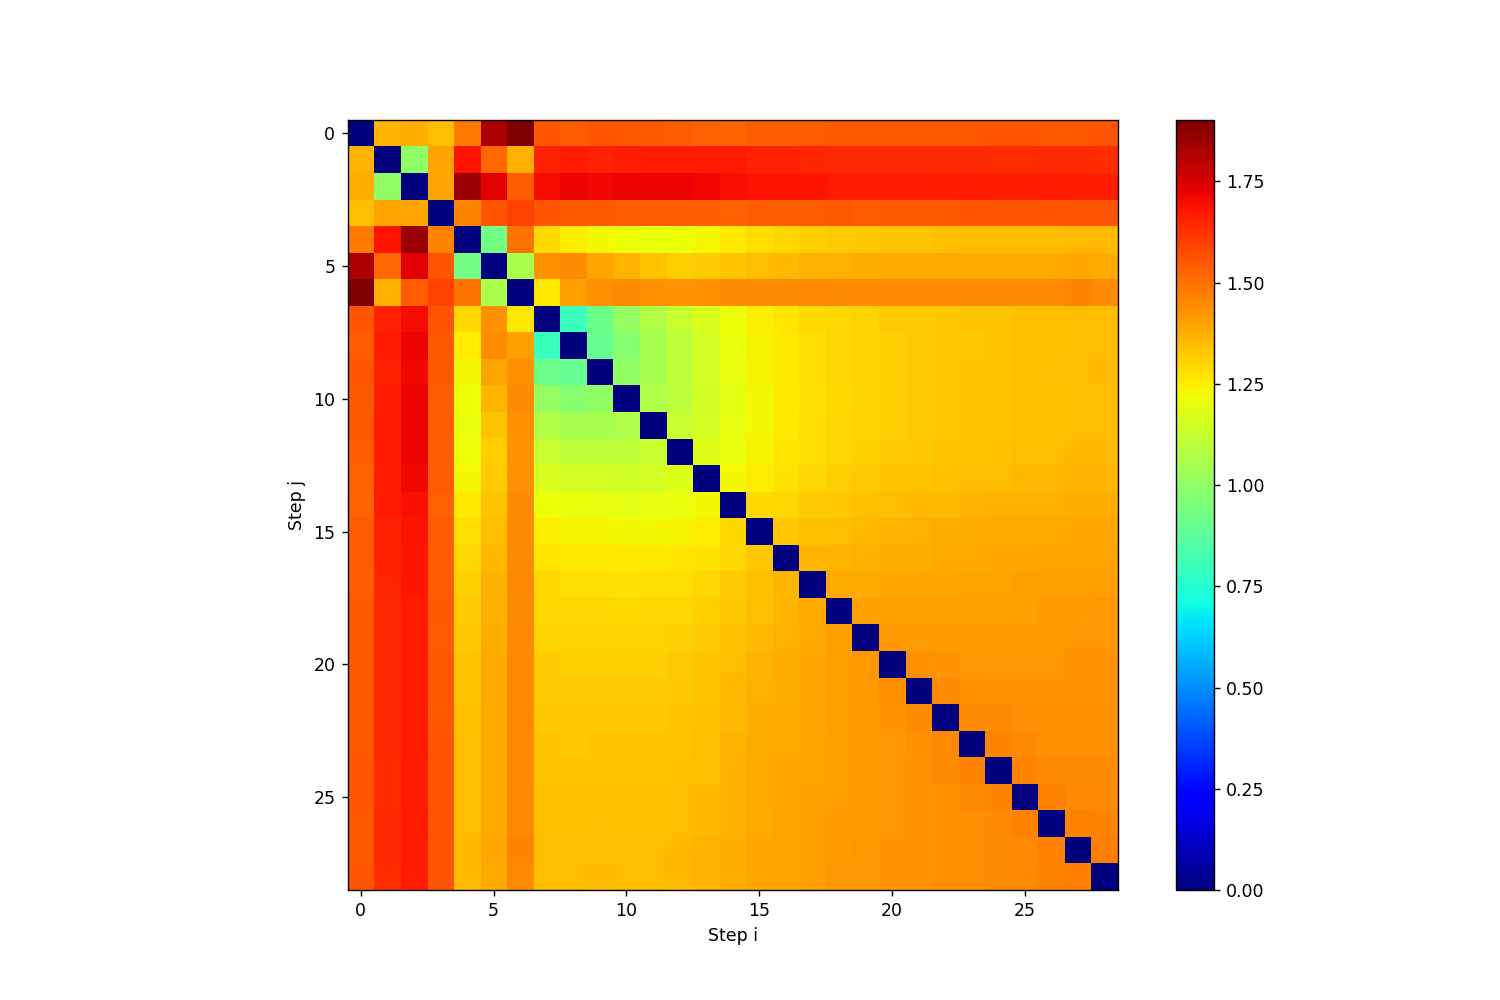

<IPython.core.display.Javascript object>


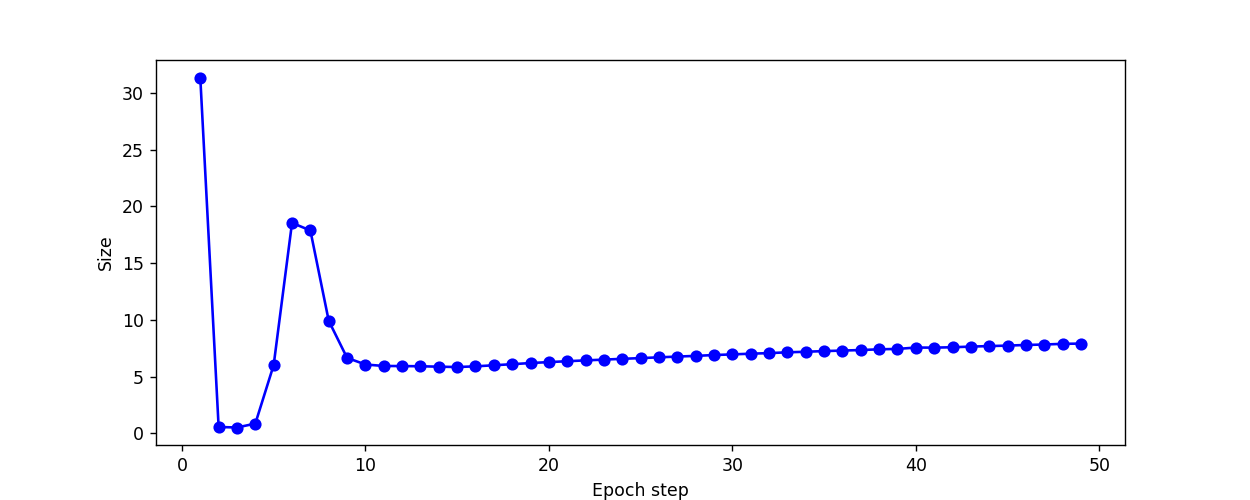

Text(0, 0.5, 'Size')

In [13]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
plt.figure()
plt.plot(np.arange(1, num_epochs), step_sizes, 'bo-')
plt.xlabel('Epoch step')
plt.ylabel('Size')